# CDDP Tutorial - Cartpole

This notebook shows how to use the CDDP algorithm to solve the cartpole problem.

© Tomohiro Sasaki, 2023

In [ ]:
import Pkg 
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [107]:
using Plots; gr()
using LinearAlgebra
using BenchmarkTools
using DataInterpolations
using DifferentialEquations
using Printf
using Revise
using CDDP


includet("../src/models/cartpole.jl")
model = CartPole();


In [123]:
tf = 5.0
tN = 100
dt = tf/tN
# x_init = [0.0, pi-0.6, 0.0, 0.0]
x_init = [0.0, 0.0, 0.0, 0.0]
x_final = [0.0, pi, 0.0, 0.0]
;

## Initial trajectory

Plots.AnimatedGif("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif")
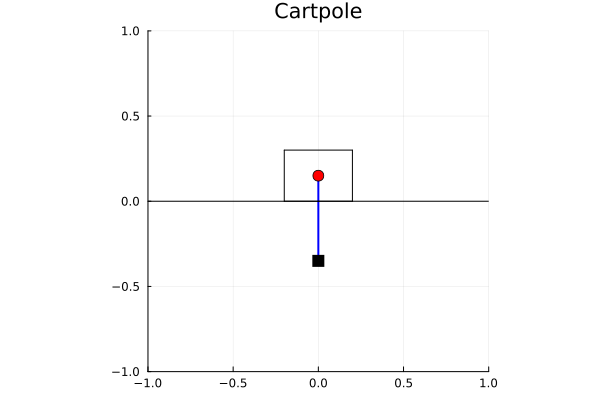

In [124]:
X0, U0 = initialize_trajectory(model, tf, tN, x_init, model.f!)
make_gif(X0, 0.01, model, example=:cartpole, filename="../results/cartpole.gif")

# Define cost function

In [152]:
function ell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = 0.5*1e-2*Diagonal([1.0, 1.0, 1.0, 1.0])
    R = 0.5*Diagonal([0.01])
    if x_ref == nothing
        return x'*Q*x + u'*R*u
    else
        return (x-x_ref)'*Q*(x-x_ref) + u'*R*u
    end
end

function phi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = 0.5*Diagonal([100.0, 100.0, 100.0, 100.0])
    if x_ref == nothing
        return x'*Qf*x
    else
        return (x-x_ref)'*Qf*(x-x_ref)
    end
end

function ∇ₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = 0.5*1e-2*Diagonal([1.0, 1.0, 1.0, 1.0])
    if x_ref == nothing
        return Q*x
    else
        return Q*(x-x_ref)
    end
end

function ∇ᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    R = 0.5*Diagonal([0.01])
    return R*u
end

function ∇ₓₓell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    Q = 0.5*1e-2*Diagonal([1.0, 1.0, 1.0, 1.0])
    return Q
end

function ∇ᵤᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    R = 0.5*Diagonal([0.01])
    return R
end

function ∇ₓᵤell_cost(x::Vector, u::Vector; x_ref::Vector=nothing)
    return zeros(4,1)
end

function ∇ₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = 0.5*Diagonal([100.0, 100.0, 100.0, 100.0])
    if x_ref == nothing
        return Qf*x
    else
        return Qf*(x-x_ref)
    end
end

function ∇ₓₓphi_cost(x::Vector; x_ref::Vector=nothing)
    Qf = 0.5*Diagonal([100.0, 100.0, 100.0, 100.0])
    return Qf
end


cost_funcs = CostFunction(
    ell=ell_cost,
    ∇ₓell=∇ₓell_cost,
    ∇ᵤell=∇ᵤell_cost,
    ∇ₓₓell=∇ₓₓell_cost,
    ∇ᵤᵤell=∇ᵤᵤell_cost,
    ∇ₓᵤell=∇ₓᵤell_cost,
    phi=phi_cost,
    ∇ₓphi=∇ₓphi_cost,
    ∇ₓₓphi=∇ₓₓphi_cost,
)


CostFunction(ell_cost, CDDP.var"#∇ell#14"{CDDP.var"#∇ell#11#15"{typeof(∇ₓell_cost), typeof(∇ᵤell_cost)}}(CDDP.var"#∇ell#11#15"{typeof(∇ₓell_cost), typeof(∇ᵤell_cost)}(∇ₓell_cost, ∇ᵤell_cost)), CDDP.var"#∇²ell#16"{CDDP.var"#∇²ell#12#17"{typeof(∇ₓₓell_cost), typeof(∇ₓᵤell_cost), typeof(∇ᵤᵤell_cost)}}(CDDP.var"#∇²ell#12#17"{typeof(∇ₓₓell_cost), typeof(∇ₓᵤell_cost), typeof(∇ᵤᵤell_cost)}(∇ₓₓell_cost, ∇ₓᵤell_cost, ∇ᵤᵤell_cost)), phi_cost, ∇ₓphi_cost, ∇ₓₓphi_cost)

## Define dynamics function

In [153]:
dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=RK4());
;
# dyn_funcs = DynamicsFunction(f=f, integrator=RK4());

In [158]:
X_ref = Vector[x_final for t in 1:tN+1]
X_ref =  ConstantInterpolation(X_ref, 0:dt:tf)
;

## iLQR solver

In [189]:
dyn_funcs = DynamicsFunction(f! =model.f!, ∇f=model.∇f, ∇²f=model.∇²f, integrator=RK4());

prob = DDPProblem(
    model=model, 
    tf=tf, 
    tN=tN, 
    dt=dt, 
    dims=model.dims,
    cost_funcs=cost_funcs,
    dyn_funcs=dyn_funcs,
    x_init=x_init, 
    x_final=x_final, 
    X_ref=X_ref)
    
sol = solve_ddp(
    prob, 
    X=nothing, 
    U=nothing, 
    isilqr=true,
    max_ite=100, 
    tol=1e-8,
    reg_param_x=1e-6, 
    reg_param_x_fact=10.0, 
    reg_param_x_lb=1e-20,
    reg_param_u=1e-4, 
    reg_param_u_fact=10.0,
    reg_param_u_lb=1e-20,
    line_search_steps = 5 .^ LinRange(0, -6, 30))
    
X, U, J, gains = sol.X, sol.U, sol.J, sol.gains;
X_ilqr, U_ilqr, J_ilqr, gains_ilqr = sol.X, sol.U, sol.J, sol.gains;

In [190]:
J

0.5215644963330335

In [191]:
X_arr = zeros(4, tN+1)

for k in 1:tN+1
    t = (k-1)*dt
    X_arr[:,k] = X(t)
end

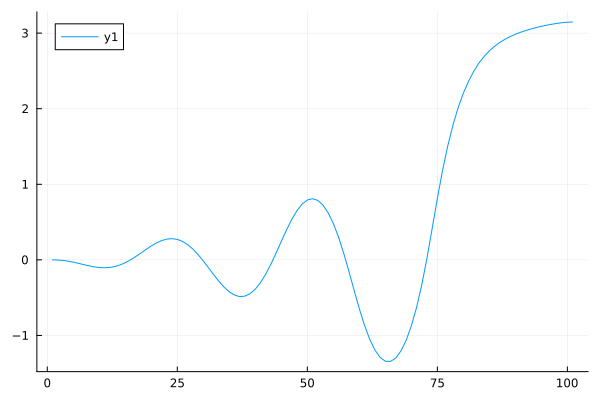

In [192]:
plot(X_arr[2,:])

Plots.AnimatedGif("/Users/astomodynamics/Dropbox (GaTech)/Dropbox_Tomo/github/CDDP.jl/results/cartpole.gif")
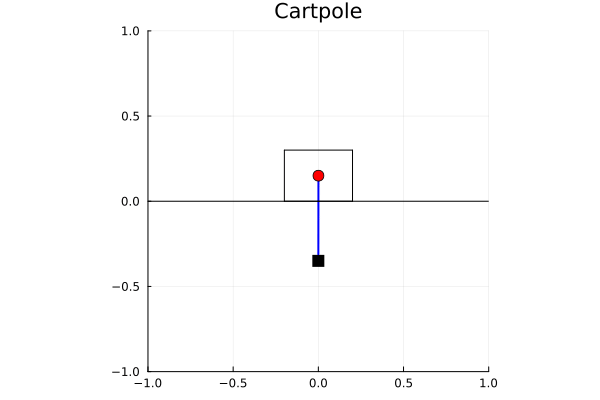

In [194]:

make_gif(X_ilqr, 0.04, model, example=:cartpole, filename="../results/cartpole.gif")

## CDDP

In [ ]:
function c_const()
    return 0.0
end

function cf_const( )
end

In [194]:
using DataInterpolations, Plots
gr()
# Dependent variable
u = [14.7, 11.51, 10.41, 14.95, 12.24, 11.22]
# Independent variable
t = [0.0, 62.25, 109.66, 162.66, 205.8, 252.3]
A = CubicSpline(u,t)

12-element CubicSpline{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, true, Float64}:
  14.7
  11.51
  10.41
  14.95
  12.24
  11.22
   0.0
  62.25
 109.66
 162.66
 205.8
 252.3

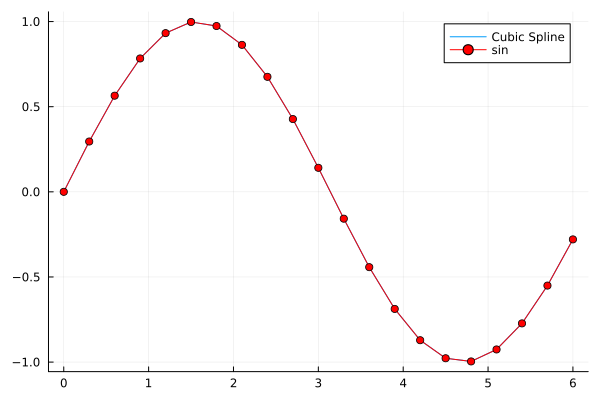

In [143]:
t = 0:0.3:2*pi
s = sin.(t)
c = cos.(t)
u = s
uu = Vector[[sin(k),cos(k)] for k in t]
# uu::Vector{Matrix{Float64}} = [[cos(k) -sin(k); sin(k) cos(k)] for k in t]
A = CubicSpline(uu,t)
A = BSplineInterpolation(u,t,4, :ArcLen,:Average)


plot(t, A.(t), label="Cubic Spline")
plot!(t, s, label="sin", linestyle=:solid, linewidth=1, color=:red, marker=:circle)

In [131]:
A_mat = zeros(2,2,length(t)+10)
for k in 1:length(t)+10
    A_mat[:,:,k] = A(k*0.01)
end

plot(A_mat[1,1,:], label="Cubic Spline")
plot!(A_mat[2,2,:], label="Cubic Spline")

ArgumentError: ArgumentError: indexed assignment with a single value to possibly many locations is not supported; perhaps use broadcasting `.=` instead?